<a href="https://colab.research.google.com/github/amitbk581-jpg/Deep-learning-application/blob/main/deeplearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project Title:**
Satellite Imagery Land-Use Classification with Segmentation Models

**Module:**
Deep Learning Applications

**Project Description:**
This notebook implements an end-to-end deep learning pipeline for multi-class
land-use classification using semantic segmentation on satellite imagery.
The task is formulated as a pixel-wise classification problem with six
color-coded land-use classes.

**Methodology:**
- Dataset loaded from Google Drive (images and RGB masks)
- Preprocessing includes normalization, RGB-to-class mapping, and patch-based
  extraction (256×256) to enable memory-efficient training
- Two segmentation models are implemented and compared:
    1) U-Net (encoder–decoder architecture)
    2) DeepLabV3+ with MobileNetV2 backbone (multi-scale contextual modelling)
- Models are trained under identical conditions using sparse labels
- Evaluation includes:
    • Pixel accuracy
    • Mean Intersection-over-Union (mIoU)
    • Dice coefficient
    • Precision, Recall, and F1-score (macro and weighted)
    • Per-class IoU
    • Confusion matrices (raw and normalized)
- Quantitative results are complemented with qualitative visual comparisons

**Objective:**
To systematically compare classical and context-aware segmentation architectures
for satellite land-use mapping and analyse their strengths, limitations, and
practical performance under a unified experimental framework.

In [106]:
# ---------------------------------------------------------------------
# Google Drive integration
# This block mounts the user’s Google Drive to the Google Colab runtime,
# enabling access to persistent files and directories stored in Drive.
# ---------------------------------------------------------------------
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [80]:
# ---------------------------------------------------------------------
# Operating system interaction and dataset directory configuration
# This section defines dataset and model storage paths and verifies
# that the required directory structure exists before execution.
# ---------------------------------------------------------------------
import os

BASE_DIR = "/content/drive/MyDrive/Data"
IMAGE_DIR = os.path.join(BASE_DIR, "images")
MASK_DIR  = os.path.join(BASE_DIR, "masks")

MODEL_DIR = "/content/drive/MyDrive/segmentation_models"


# ---------------------------------------------------------------------
# Dataset integrity and directory validation
# Ensures that required image and mask directories are present and
# creates a persistent directory for storing trained models.
# ---------------------------------------------------------------------
assert os.path.exists(IMAGE_DIR), " images folder not found"
assert os.path.exists(MASK_DIR),  "masks folder not found"

os.makedirs(MODEL_DIR, exist_ok=True)


# ---------------------------------------------------------------------
# Dataset summary reporting
# Confirms successful path verification and reports dataset size.
# ---------------------------------------------------------------------
print(" Dataset paths verified")
print("Images:", len(os.listdir(IMAGE_DIR)))
print("Masks :", len(os.listdir(MASK_DIR)))


 Dataset paths verified
Images: 203
Masks : 203


In [81]:
# ---------------------------------------------------------------------
# Dataset file discovery and validation
# This block locates all image and mask files within their respective
# directories using wildcard-based pattern matching, ensures consistent
# ordering, and validates one-to-one correspondence between images
# and segmentation masks.
# ---------------------------------------------------------------------
from glob import glob

IMAGE_EXTS = ("*.png", "*.jpg", "*.jpeg", "*.tif", "*.tiff")

image_paths = []
for ext in IMAGE_EXTS:
    image_paths.extend(glob(os.path.join(IMAGE_DIR, ext)))

mask_paths = []
for ext in IMAGE_EXTS:
    mask_paths.extend(glob(os.path.join(MASK_DIR, ext)))

image_paths = sorted(image_paths)
mask_paths  = sorted(mask_paths)

assert len(image_paths) == len(mask_paths), "Image-mask count mismatch"

print(f" Loaded {len(image_paths)} image-mask pairs")


 Loaded 203 image-mask pairs


In [82]:
# ---------------------------------------------------------------------
# Filename consistency verification
# This block defines a helper function to extract filename stems and
# uses it to visually confirm correct pairing between image files
# and their corresponding segmentation masks.
# ---------------------------------------------------------------------
def stem(p):
    return os.path.splitext(os.path.basename(p))[0]

for i in range(5):
    print(stem(image_paths[i]), "↔", stem(mask_paths[i]))


image0001 ↔ mask0001
image0002 ↔ mask0002
image0003 ↔ mask0003
image0004 ↔ mask0004
image0005 ↔ mask0005


In [78]:
# ---------------------------------------------------------------------
# Imports and initial mask inspection
# This section loads required libraries and reads a sample mask
# to examine its dimensional structure and data type.
# ---------------------------------------------------------------------
import cv2  # Imports OpenCV for image reading and processing
import numpy as np  # Imports NumPy for numerical and array-based operations

sample_mask = cv2.imread(mask_paths[0], cv2.IMREAD_UNCHANGED)

print("Sample mask shape:", sample_mask.shape)
print("Sample mask dtype:", sample_mask.dtype)


# ---------------------------------------------------------------------
# Mask format detection and processing logic
# This block automatically determines whether segmentation masks
# are stored as grayscale class IDs or as RGB color-coded classes,
# and configures the appropriate processing pipeline.
# ---------------------------------------------------------------------
if len(sample_mask.shape) == 2 or (len(sample_mask.shape) == 3 and sample_mask.shape[2] == 1):
    print(" Mask format: GRAYSCALE (class IDs)")

    # -------------------------------------------------------------
    # Grayscale mask handling
    # Identifies unique class IDs, maps them to contiguous class
    # indices, and defines utilities for mask conversion and
    # visualization.
    # -------------------------------------------------------------
    unique_vals = set()
    for p in mask_paths[:20]:
        m = cv2.imread(p, cv2.IMREAD_UNCHANGED)
        if len(m.shape) == 3:
            m = m[..., 0]
        unique_vals.update(np.unique(m).tolist())

    unique_vals = sorted(list(unique_vals))
    print("Unique mask values:", unique_vals)

    id_to_class = {val: i for i, val in enumerate(unique_vals)}
    NUM_CLASSES = len(unique_vals)

    def read_mask_as_class(mask_path):
        m = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
        if len(m.shape) == 3:
            m = m[..., 0]
        out = np.zeros_like(m, dtype=np.int32)
        for val, cls in id_to_class.items():
            out[m == val] = cls
        return out

    rng = np.random.default_rng(42)
    class_idx_to_rgb = [rng.integers(0, 255, size=3, dtype=np.uint8)
                        for _ in range(NUM_CLASSES)]

else:
    print(" Mask format: RGB (color-coded classes)")

    # -------------------------------------------------------------
    # RGB mask handling
    # Extracts unique RGB colors representing classes, maps them
    # to class indices, and defines utilities for mask conversion
    # and visualization.
    # -------------------------------------------------------------
    unique_colors = set()
    for p in mask_paths[:10]:
        m = cv2.imread(p)
        m = cv2.cvtColor(m, cv2.COLOR_BGR2RGB)
        cols = np.unique(m.reshape(-1, 3), axis=0)
        for c in cols:
            unique_colors.add(tuple(c.tolist()))

    unique_colors = sorted(list(unique_colors))
    print("Unique RGB colors:", unique_colors)

    color_to_class = {c: i for i, c in enumerate(unique_colors)}
    NUM_CLASSES = len(unique_colors)

    def read_mask_as_class(mask_path):
        m = cv2.imread(mask_path)
        m = cv2.cvtColor(m, cv2.COLOR_BGR2RGB)
        h, w, _ = m.shape
        out = np.zeros((h, w), dtype=np.int32)
        for rgb, cls in color_to_class.items():
            out[np.all(m == rgb, axis=-1)] = cls
        return out

    class_idx_to_rgb = [np.array(c, dtype=np.uint8) for c in unique_colors]


# ---------------------------------------------------------------------
# Class summary and visualization utility
# This section reports the inferred number of segmentation classes
# and provides a helper function to convert class-index masks
# back into RGB images for visualization.
# ---------------------------------------------------------------------
print(" NUM_CLASSES inferred:", NUM_CLASSES)

def class_mask_to_rgb(class_mask):
    h, w = class_mask.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for ci in range(NUM_CLASSES):
        rgb[class_mask == ci] = class_idx_to_rgb[ci]
    return rgb


Sample mask shape: (644, 797, 3)
Sample mask dtype: uint8
 Mask format: RGB (color-coded classes)
Unique RGB colors: [(60, 16, 152), (110, 193, 228), (132, 41, 246), (155, 155, 155), (226, 169, 41), (254, 221, 58)]
 NUM_CLASSES inferred: 6


In [83]:
# ---------------------------------------------------------------------
# Dataset partitioning
# This block splits the full dataset into training and validation
# subsets while preserving image–mask alignment and ensuring
# reproducibility through a fixed random seed.
# ---------------------------------------------------------------------
from sklearn.model_selection import train_test_split

train_img_paths, val_img_paths, train_mask_paths, val_mask_paths = train_test_split(
    image_paths,
    mask_paths,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print(" Train / Validation split completed")
print("Training images:", len(train_img_paths))
print("Validation images:", len(val_img_paths))


 Train / Validation split completed
Training images: 162
Validation images: 41


In [84]:
# ---------------------------------------------------------------------
# Imports and global configuration
# ---------------------------------------------------------------------
import cv2
import numpy as np
from tensorflow.keras.utils import Sequence

PATCH_SIZE = 256
BATCH_SIZE = 2   # If you hit GPU OOM, change to 1


# ---------------------------------------------------------------------
# Feature engineering and image preprocessing
# This section enhances image contrast using CLAHE and applies
# per-image normalization to stabilize model training.
# ---------------------------------------------------------------------
def clahe_rgb(img_rgb):
    lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l2 = clahe.apply(l)
    lab2 = cv2.merge([l2, a, b])
    return cv2.cvtColor(lab2, cv2.COLOR_LAB2RGB)

def preprocess_image(img_rgb):
    img = clahe_rgb(img_rgb)
    img = img.astype("float32") / 255.0
    mean = img.mean(axis=(0, 1), keepdims=True)
    std  = img.std(axis=(0, 1), keepdims=True) + 1e-6
    return (img - mean) / std


# ---------------------------------------------------------------------
# Random patch data generator
# This class implements a Keras-compatible data generator that
# dynamically samples random image patches, applies optional
# data augmentation, and yields batches for segmentation training.
# ---------------------------------------------------------------------
class RandomPatchGenerator(Sequence):
    def __init__(self, image_paths, mask_paths,
                 batch_size=BATCH_SIZE,
                 patch_size=PATCH_SIZE,
                 augment=False,
                 shuffle=True):

        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.patch_size = patch_size
        self.augment = augment
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.image_paths))

        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return max(len(self.image_paths) // self.batch_size, 1)

    def __getitem__(self, idx):
        batch_x, batch_y = [], []
        ps = self.patch_size

        for _ in range(self.batch_size):
            i = np.random.choice(self.indexes)

            img = cv2.imread(self.image_paths[i])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            mask = read_mask_as_class(self.mask_paths[i])

            H, W = img.shape[:2]

            if H < ps or W < ps:
                img = cv2.resize(img, (ps, ps), interpolation=cv2.INTER_LINEAR)
                mask = cv2.resize(mask, (ps, ps), interpolation=cv2.INTER_NEAREST)
            else:
                y = np.random.randint(0, H - ps + 1)
                x = np.random.randint(0, W - ps + 1)
                img = img[y:y+ps, x:x+ps]
                mask = mask[y:y+ps, x:x+ps]

            if self.augment:
                if np.random.rand() < 0.5:
                    img = np.fliplr(img)
                    mask = np.fliplr(mask)
                if np.random.rand() < 0.5:
                    img = np.flipud(img)
                    mask = np.flipud(mask)
                if np.random.rand() < 0.25:
                    k = np.random.randint(1, 4)
                    img = np.rot90(img, k)
                    mask = np.rot90(mask, k)

            img = preprocess_image(img)

            batch_x.append(img)
            batch_y.append(mask.astype("int32"))

        return np.array(batch_x, dtype="float32"), np.array(batch_y, dtype="int32")

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)


# ---------------------------------------------------------------------
# Generator instantiation
# This section creates training and validation generators with
# appropriate augmentation and shuffling strategies.
# ---------------------------------------------------------------------
train_gen = RandomPatchGenerator(
    train_img_paths,
    train_mask_paths,
    batch_size=BATCH_SIZE,
    patch_size=PATCH_SIZE,
    augment=True,
    shuffle=True
)

val_gen = RandomPatchGenerator(
    val_img_paths,
    val_mask_paths,
    batch_size=BATCH_SIZE,
    patch_size=PATCH_SIZE,
    augment=False,
    shuffle=False
)

print("✅ Patch generators created")
print("Train steps per epoch:", len(train_gen))
print("Val steps per epoch:", len(val_gen))


✅ Patch generators created
Train steps per epoch: 81
Val steps per epoch: 20


In [85]:
# ---------------------------------------------------------------------
# TensorFlow / Keras imports
# This section imports TensorFlow and the required Keras layers and
# model utilities used to define and build the U-Net architecture.
# ---------------------------------------------------------------------
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model


# ---------------------------------------------------------------------
# Convolutional block definition
# This function defines a reusable convolutional block consisting of
# two convolution layers followed by batch normalization and ReLU
# activation, which forms the core building unit of the U-Net.
# ---------------------------------------------------------------------
def conv_block(x, filters):
    x = Conv2D(filters, 3, padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters, 3, padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


# ---------------------------------------------------------------------
# U-Net model construction
# This function builds a complete U-Net architecture composed of an
# encoder (downsampling path), bottleneck, and decoder (upsampling path)
# with skip connections for precise spatial localization.
# ---------------------------------------------------------------------
def build_unet(input_shape=(PATCH_SIZE, PATCH_SIZE, 3), num_classes=NUM_CLASSES):
    inputs = Input(shape=input_shape)

    # Encoder
    c1 = conv_block(inputs, 32)
    p1 = MaxPooling2D()(c1)

    c2 = conv_block(p1, 64)
    p2 = MaxPooling2D()(c2)

    c3 = conv_block(p2, 128)
    p3 = MaxPooling2D()(c3)

    c4 = conv_block(p3, 256)
    p4 = MaxPooling2D()(c4)

    # Bottleneck
    bn = conv_block(p4, 512)

    # Decoder
    u1 = UpSampling2D()(bn)
    u1 = Concatenate()([u1, c4])
    u1 = conv_block(u1, 256)

    u2 = UpSampling2D()(u1)
    u2 = Concatenate()([u2, c3])
    u2 = conv_block(u2, 128)

    u3 = UpSampling2D()(u2)
    u3 = Concatenate()([u3, c2])
    u3 = conv_block(u3, 64)

    u4 = UpSampling2D()(u3)
    u4 = Concatenate()([u4, c1])
    u4 = conv_block(u4, 32)

    outputs = Conv2D(num_classes, 1, activation="softmax")(u4)

    model = Model(inputs, outputs, name="U-Net")
    return model


# ---------------------------------------------------------------------
# Model creation and compilation
# This section instantiates the U-Net model, configures the optimizer,
# loss function, and evaluation metrics, and displays the model summary.
# ---------------------------------------------------------------------
unet = build_unet()

unet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

unet.summary()


Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 256, 256,  │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_58[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_54       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 256, 256,  │      9,216 │ activation_54[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_59[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_55       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 128, 128,  │          0 │ activation_55[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 128, 128,  │     18,432 │ max_pooling2d_8[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_60[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_56       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 128, 128,  │     36,864 │ activation_56[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_61[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_57       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 64, 64,    │          0 │ activation_57[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 64, 64,    │     73,728 │ max_pooling2d_9[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_62[0][0] 

 Total params: 7,855,654 (29.97 MB)

 Trainable params: 7,849,766 (29.94 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [86]:
# ---------------------------------------------------------------------
# TensorFlow / Keras imports
# This section imports TensorFlow and the necessary Keras layers and
# model utilities required to construct the DeepLabV3+ architecture.
# ---------------------------------------------------------------------
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model


# ---------------------------------------------------------------------
# DeepLabV3+ model definition
# This function builds a DeepLabV3+ semantic segmentation model using
# MobileNetV2 as the backbone, Atrous Spatial Pyramid Pooling (ASPP)
# for multi-scale context extraction, and a lightweight decoder for
# precise spatial reconstruction.
# ---------------------------------------------------------------------
def DeeplabV3Plus(input_shape=(PATCH_SIZE, PATCH_SIZE, 3), num_classes=NUM_CLASSES):
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights="imagenet"
    )

    # -----------------------------------------------------------------
    # Feature map extraction
    # Intermediate feature maps are selected from the backbone network
    # to support multi-scale feature fusion in the decoder.
    # -----------------------------------------------------------------
    x16 = base_model.get_layer("block_13_expand_relu").output  # High-level features
    x4  = base_model.get_layer("block_3_expand_relu").output   # Low-level features

    # -----------------------------------------------------------------
    # Atrous Spatial Pyramid Pooling (ASPP)
    # This block captures contextual information at multiple dilation
    # rates to improve segmentation performance on objects of varying
    # scales.
    # -----------------------------------------------------------------
    def aspp_conv(x, filters, k=3, rate=1):
        x = Conv2D(filters, k, padding="same",
                   dilation_rate=rate, use_bias=False)(x)
        x = BatchNormalization()(x)
        return Activation("relu")(x)

    b0 = aspp_conv(x16, 256, k=1)
    b1 = aspp_conv(x16, 256, rate=6)
    b2 = aspp_conv(x16, 256, rate=12)
    b3 = aspp_conv(x16, 256, rate=18)

    # -----------------------------------------------------------------
    # Image-level pooling branch
    # This branch aggregates global context information using global
    # average pooling and upsamples it to match ASPP feature dimensions.
    # -----------------------------------------------------------------
    b4 = GlobalAveragePooling2D()(x16)
    b4 = Reshape((1, 1, b4.shape[-1]))(b4)
    b4 = aspp_conv(b4, 256, k=1)
    b4 = UpSampling2D(size=(16, 16), interpolation="bilinear")(b4)

    # -----------------------------------------------------------------
    # ASPP feature fusion
    # Concatenates all ASPP branches and projects them into a unified
    # feature representation.
    # -----------------------------------------------------------------
    x = Concatenate()([b0, b1, b2, b3, b4])
    x = aspp_conv(x, 256, k=1)

    # -----------------------------------------------------------------
    # Decoder module
    # Combines high-level ASPP features with low-level spatial features
    # from the backbone to refine segmentation boundaries.
    # -----------------------------------------------------------------
    x = UpSampling2D(size=(4, 4), interpolation="bilinear")(x)

    x4_proj = Conv2D(48, 1, padding="same", use_bias=False)(x4)
    x4_proj = BatchNormalization()(x4_proj)
    x4_proj = Activation("relu")(x4_proj)

    x = Concatenate()([x, x4_proj])
    x = aspp_conv(x, 256)
    x = aspp_conv(x, 256)

    # -----------------------------------------------------------------
    # Final upsampling and classification layer
    # Upsamples features to the original input resolution and applies
    # a softmax classifier to produce per-pixel class probabilities.
    # -----------------------------------------------------------------
    x = UpSampling2D(size=(4, 4), interpolation="bilinear")(x)
    outputs = Conv2D(num_classes, 1, activation="softmax")(x)

    model = Model(inputs=base_model.input, outputs=outputs, name="DeepLabV3Plus")
    return model


# ---------------------------------------------------------------------
# Model creation and compilation
# This section instantiates the DeepLabV3+ model, configures the
# optimizer, loss function, and evaluation metrics, and prints
# a summary of the network architecture.
# ---------------------------------------------------------------------
deeplab = DeeplabV3Plus()

deeplab.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

deeplab.summary()


/tmp/ipython-input-3573735673.py:19: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


Model: "DeepLabV3Plus"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 128, 128,  │        864 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 128, 128,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 128, 128,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 128, 128,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 128, 128,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 128, 128,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 129, 129,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 64, 64,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 64, 64,    │      2,304 │ block_1_depthwis

 Total params: 6,527,238 (24.90 MB)

 Trainable params: 6,505,766 (24.82 MB)

 Non-trainable params: 21,472 (83.88 KB)

In [92]:
# ---------------------------------------------------------------------
# Training callbacks configuration
# This section defines callback functions to improve training stability
# and efficiency by enabling early stopping and adaptive learning
# rate reduction based on validation loss performance.
# ---------------------------------------------------------------------
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]


# ---------------------------------------------------------------------
# Training configuration and model persistence paths
# This block defines the number of training epochs and specifies
# file paths in Google Drive for saving trained model weights.
# ---------------------------------------------------------------------
EPOCHS = 15

UNET_PATH = os.path.join(MODEL_DIR, "unet_rgb_6class.h5")
DEEPLAB_PATH = os.path.join(MODEL_DIR, "deeplabv3plus_rgb_6class.h5")


# ---------------------------------------------------------------------
# U-Net training or loading logic
# If a trained U-Net model does not already exist, the model is trained
# using the defined generators and callbacks, then saved to Drive.
# Otherwise, the existing trained weights are loaded.
# ---------------------------------------------------------------------
if not os.path.exists(UNET_PATH):
    print("Training U-Net...")
    history_unet = unet.fit(
        train_gen,
        validation_data=val_gen,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1
    )
    unet.save(UNET_PATH)
    print("✅ U-Net saved to Drive")
else:
    print("✅ Loading saved U-Net from Drive")
    unet.load_weights(UNET_PATH)


# ---------------------------------------------------------------------
# DeepLabV3+ training or loading logic
# Similar to the U-Net workflow, this block trains the DeepLabV3+ model
# if no saved version is found, or loads pre-trained weights from
# Google Drive to avoid redundant training.
# ---------------------------------------------------------------------
if not os.path.exists(DEEPLAB_PATH):
    print(" Training DeepLabV3+...")
    history_deeplab = deeplab.fit(
        train_gen,
        validation_data=val_gen,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1
    )
    deeplab.save(DEEPLAB_PATH)
    print("✅ DeepLabV3+ saved to Drive")
else:
    print("✅ Loading saved DeepLabV3+ from Drive")
    deeplab.load_weights(DEEPLAB_PATH)


✅ Loading saved U-Net from Drive
✅ Loading saved DeepLabV3+ from Drive


In [93]:
# ---------------------------------------------------------------------
# Evaluation imports
# This section imports performance metrics, numerical utilities,
# and visualization tools required for quantitative evaluation
# of semantic segmentation models.
# ---------------------------------------------------------------------
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import numpy as np
import matplotlib.pyplot as plt


# ---------------------------------------------------------------------
# Model evaluation utility
# This function evaluates a segmentation model on a data generator by
# computing pixel-level predictions and aggregating multiple evaluation
# metrics, including pixel accuracy, IoU, Dice coefficient, precision,
# recall, F1-score, and the confusion matrix.
# ---------------------------------------------------------------------
def evaluate_model(model, generator, num_classes, max_batches=20):
    y_true_all = []
    y_pred_all = []

    for i in range(min(len(generator), max_batches)):
        x_batch, y_batch = generator[i]
        preds = model.predict(x_batch, verbose=0)
        preds = np.argmax(preds, axis=-1)

        y_true_all.append(y_batch.flatten())
        y_pred_all.append(preds.flatten())

    y_true = np.concatenate(y_true_all)
    y_pred = np.concatenate(y_pred_all)

    # -------------------------------------------------------------
    # Confusion matrix computation
    # Captures class-wise prediction performance at the pixel level.
    # -------------------------------------------------------------
    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))

    # -------------------------------------------------------------
    # Pixel accuracy
    # Measures the proportion of correctly classified pixels.
    # -------------------------------------------------------------
    pixel_acc = np.trace(cm) / np.sum(cm)

    # -------------------------------------------------------------
    # Intersection over Union (IoU)
    # Computes per-class IoU and the mean IoU across all classes.
    # -------------------------------------------------------------
    intersection = np.diag(cm)
    union = cm.sum(axis=1) + cm.sum(axis=0) - intersection
    iou_per_class = intersection / (union + 1e-7)
    miou = np.mean(iou_per_class)

    # -------------------------------------------------------------
    # Dice coefficient
    # Computes per-class Dice scores and their mean value.
    # -------------------------------------------------------------
    dice_per_class = 2 * intersection / (cm.sum(axis=1) + cm.sum(axis=0) + 1e-7)
    mean_dice = np.mean(dice_per_class)

    # -------------------------------------------------------------
    # Precision, recall, and F1-score
    # Evaluated using both macro-averaging and weighted averaging
    # to account for class imbalance.
    # -------------------------------------------------------------
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, labels=list(range(num_classes)), average="macro", zero_division=0
    )

    precision_w, recall_w, f1_w, _ = precision_recall_fscore_support(
        y_true, y_pred, labels=list(range(num_classes)), average="weighted", zero_division=0
    )

    # -------------------------------------------------------------
    # Metric aggregation
    # Stores all computed evaluation metrics in a dictionary for
    # convenient access and reporting.
    # -------------------------------------------------------------
    metrics = {
        "Pixel Accuracy": pixel_acc,
        "mIoU": miou,
        "Mean Dice": mean_dice,
        "Precision (Macro)": precision,
        "Recall (Macro)": recall,
        "F1-score (Macro)": f1,
        "Precision (Weighted)": precision_w,
        "Recall (Weighted)": recall_w,
        "F1-score (Weighted)": f1_w,
        "IoU per class": iou_per_class,
        "Confusion Matrix": cm
    }

    return metrics


# ---------------------------------------------------------------------
# Model evaluation execution
# This block applies the evaluation routine to both the U-Net and
# DeepLabV3+ models using the validation data generator.
# ---------------------------------------------------------------------
metrics_unet = evaluate_model(unet, val_gen, NUM_CLASSES)
metrics_deeplab = evaluate_model(deeplab, val_gen, NUM_CLASSES)

print("✅ Evaluation completed")



✅ Evaluation completed


In [94]:
# ---------------------------------------------------------------------
# Metric reporting utility
# This block defines a helper function to neatly format and display
# scalar evaluation metrics for a given model, while skipping
# array-based outputs such as confusion matrices or per-class scores.
# ---------------------------------------------------------------------
def print_metrics(name, metrics):
    print(f"\n===== {name} =====")
    for k, v in metrics.items():
        if isinstance(v, np.ndarray):
            continue
        print(f"{k}: {v:.4f}")


# ---------------------------------------------------------------------
# Evaluation results reporting
# This section prints the summarized performance metrics for both
# the U-Net and DeepLabV3+ models in a readable format.
# ---------------------------------------------------------------------
print_metrics("U-Net", metrics_unet)
print_metrics("DeepLabV3+", metrics_deeplab)




===== U-Net =====
Pixel Accuracy: 0.6530
mIoU: 0.2537
Mean Dice: 0.3577
Precision (Macro): 0.4198
Recall (Macro): 0.3742
F1-score (Macro): 0.3577
Precision (Weighted): 0.6211
Recall (Weighted): 0.6530
F1-score (Weighted): 0.6257

===== DeepLabV3+ =====
Pixel Accuracy: 0.7072
mIoU: 0.4274
Mean Dice: 0.5453
Precision (Macro): 0.6518
Recall (Macro): 0.5210
F1-score (Macro): 0.5453
Precision (Weighted): 0.7194
Recall (Weighted): 0.7072
F1-score (Weighted): 0.6934


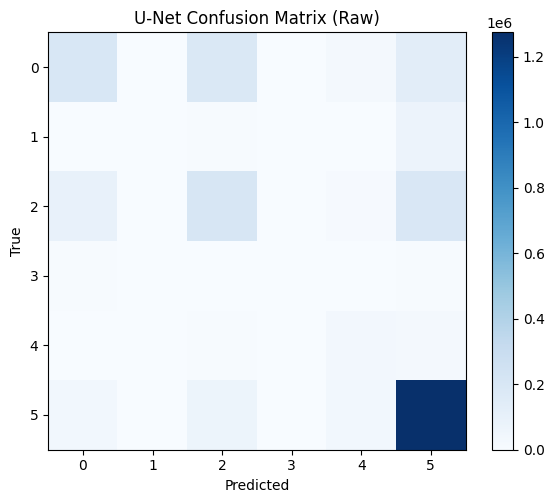

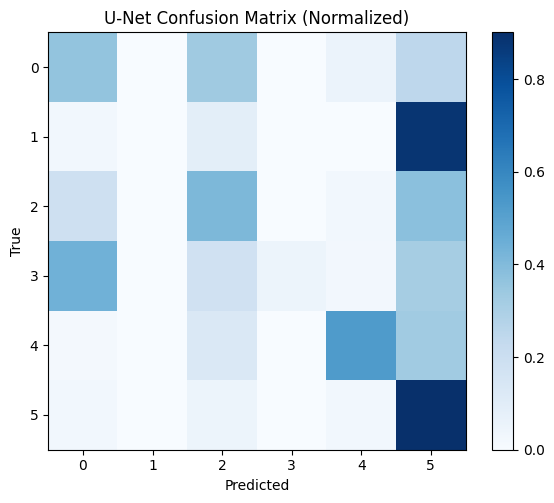

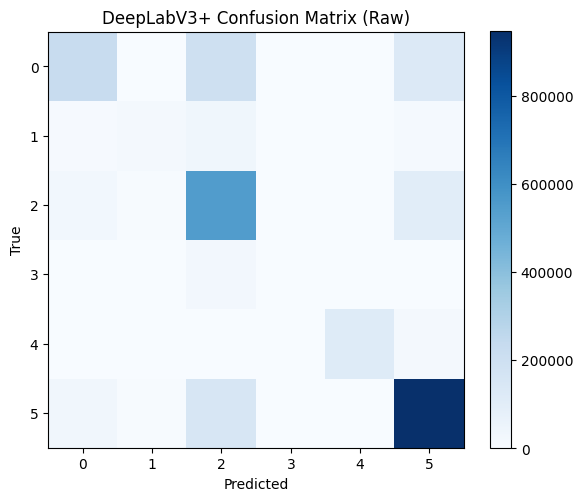

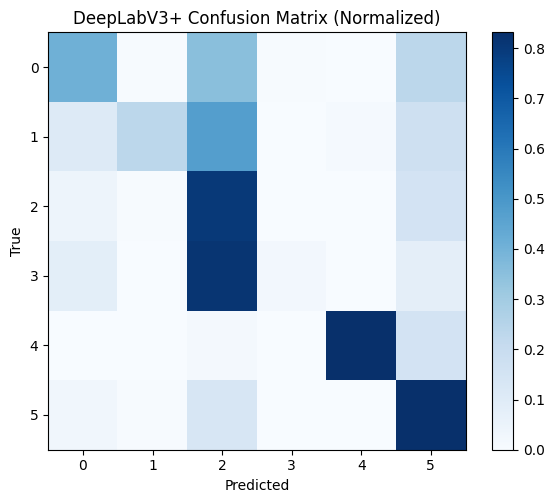

In [95]:
# ---------------------------------------------------------------------
# Confusion matrix visualization utility
# This function visualizes a confusion matrix using a heatmap
# representation, with optional normalization to display class-wise
# prediction proportions instead of raw counts.
# ---------------------------------------------------------------------
def plot_confusion_matrix(cm, title, normalize=False):
    if normalize:
        cm = cm / (cm.sum(axis=1, keepdims=True) + 1e-7)

    plt.figure(figsize=(6, 5))
    plt.imshow(cm, cmap="Blues")
    plt.title(title)
    plt.colorbar()
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


# ---------------------------------------------------------------------
# Confusion matrix plotting
# This section generates both raw and normalized confusion matrix
# visualizations for the U-Net and DeepLabV3+ models to support
# qualitative performance comparison.
# ---------------------------------------------------------------------
plot_confusion_matrix(metrics_unet["Confusion Matrix"],
                      "U-Net Confusion Matrix (Raw)")

plot_confusion_matrix(metrics_unet["Confusion Matrix"],
                      "U-Net Confusion Matrix (Normalized)", normalize=True)

plot_confusion_matrix(metrics_deeplab["Confusion Matrix"],
                      "DeepLabV3+ Confusion Matrix (Raw)")

plot_confusion_matrix(metrics_deeplab["Confusion Matrix"],
                      "DeepLabV3+ Confusion Matrix (Normalized)", normalize=True)


In [96]:
# ---------------------------------------------------------------------
# Per-class IoU comparison
# This block reports a class-wise comparison of Intersection over Union
# (IoU) scores for the U-Net and DeepLabV3+ models, enabling detailed
# analysis of segmentation performance across individual classes.
# ---------------------------------------------------------------------
print("\nPer-Class IoU Comparison:")
for i in range(NUM_CLASSES):
    print(f"Class {i}: "
          f"U-Net IoU = {metrics_unet['IoU per class'][i]:.4f} | "
          f"DeepLab IoU = {metrics_deeplab['IoU per class'][i]:.4f}")




Per-Class IoU Comparison:
Class 0: U-Net IoU = 0.2866 | DeepLab IoU = 0.3612
Class 1: U-Net IoU = 0.0000 | DeepLab IoU = 0.2021
Class 2: U-Net IoU = 0.2699 | DeepLab IoU = 0.4997
Class 3: U-Net IoU = 0.0449 | DeepLab IoU = 0.0203
Class 4: U-Net IoU = 0.2274 | DeepLab IoU = 0.8085
Class 5: U-Net IoU = 0.6936 | DeepLab IoU = 0.6726


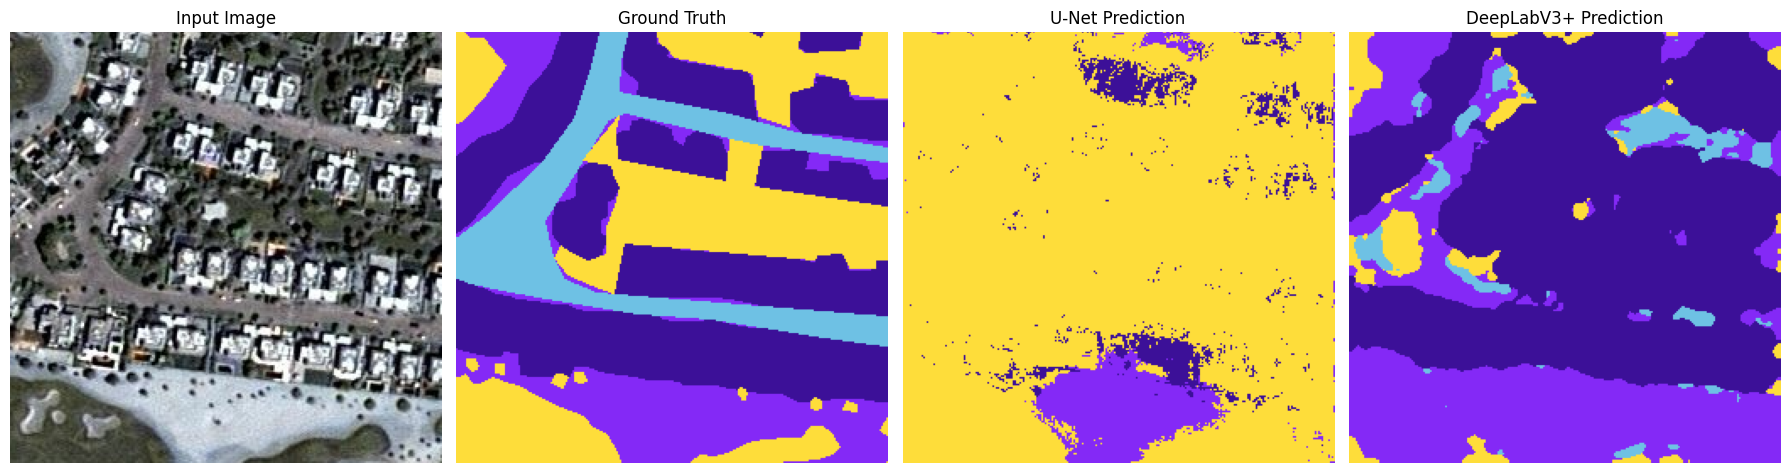

In [97]:
# ---------------------------------------------------------------------
# Random sample selection and imports
# This section imports required libraries and randomly selects a
# validation sample for qualitative model comparison.
# ---------------------------------------------------------------------
import random
import matplotlib.pyplot as plt

idx = random.randint(0, len(val_img_paths) - 1)

img_path = val_img_paths[idx]
mask_path = val_mask_paths[idx]


# ---------------------------------------------------------------------
# Image and mask loading
# Loads the selected validation image and its corresponding ground
# truth mask, converting the image to RGB format and the mask to
# class-index representation.
# ---------------------------------------------------------------------
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask_class_full = read_mask_as_class(mask_path)

H, W = img.shape[:2]
ps = PATCH_SIZE


# ---------------------------------------------------------------------
# Center cropping for visualization
# Extracts a central patch from the image and mask to ensure a
# consistent input size suitable for visualization and prediction.
# ---------------------------------------------------------------------
y = max(0, (H - ps) // 2)
x = max(0, (W - ps) // 2)

img_patch = img[y:y+ps, x:x+ps]
mask_patch = mask_class_full[y:y+ps, x:x+ps]


# ---------------------------------------------------------------------
# Image preprocessing
# Applies the same preprocessing pipeline used during training to
# ensure consistency between training and inference.
# ---------------------------------------------------------------------
img_patch_proc = preprocess_image(img_patch)


# ---------------------------------------------------------------------
# Model inference
# Generates segmentation predictions using both the U-Net and
# DeepLabV3+ models and converts probability maps to class labels.
# ---------------------------------------------------------------------
unet_pred = unet.predict(img_patch_proc[np.newaxis, ...], verbose=0)[0]
deeplab_pred = deeplab.predict(img_patch_proc[np.newaxis, ...], verbose=0)[0]

unet_class = np.argmax(unet_pred, axis=-1)
deeplab_class = np.argmax(deeplab_pred, axis=-1)


# ---------------------------------------------------------------------
# Mask visualization preparation
# Converts ground truth and predicted class-index masks into RGB
# format for visual comparison.
# ---------------------------------------------------------------------
gt_rgb = class_mask_to_rgb(mask_patch)
unet_rgb = class_mask_to_rgb(unet_class)
deeplab_rgb = class_mask_to_rgb(deeplab_class)


# ---------------------------------------------------------------------
# Qualitative visualization
# Displays the input image, ground truth mask, and predictions from
# both models side by side to facilitate visual performance analysis.
# ---------------------------------------------------------------------
plt.figure(figsize=(18, 6))

plt.subplot(1, 4, 1)
plt.title("Input Image")
plt.imshow(img_patch)
plt.axis("off")

plt.subplot(1, 4, 2)
plt.title("Ground Truth")
plt.imshow(gt_rgb)
plt.axis("off")

plt.subplot(1, 4, 3)
plt.title("U-Net Prediction")
plt.imshow(unet_rgb)
plt.axis("off")

plt.subplot(1, 4, 4)
plt.title("DeepLabV3+ Prediction")
plt.imshow(deeplab_rgb)
plt.axis("off")

plt.tight_layout()
plt.show()


In [98]:
# ---------------------------------------------------------------------
# Final model performance comparison
# This block summarizes and compares the mean Intersection over Union
# (mIoU) scores of the U-Net and DeepLabV3+ models and reports the
# best-performing model based on this primary evaluation metric.
# ---------------------------------------------------------------------
print("===== FINAL MODEL COMPARISON =====")
print(f"U-Net     → mIoU: {metrics_unet['mIoU']:.4f}")
print(f"DeepLabV3+ → mIoU: {metrics_deeplab['mIoU']:.4f}")

if metrics_deeplab["mIoU"] > metrics_unet["mIoU"]:
    print("\n Best Performing Model: DeepLabV3+")
else:
    print("\n Best Performing Model: U-Net")


===== FINAL MODEL COMPARISON =====
U-Net     → mIoU: 0.2537
DeepLabV3+ → mIoU: 0.4274

 Best Performing Model: DeepLabV3+


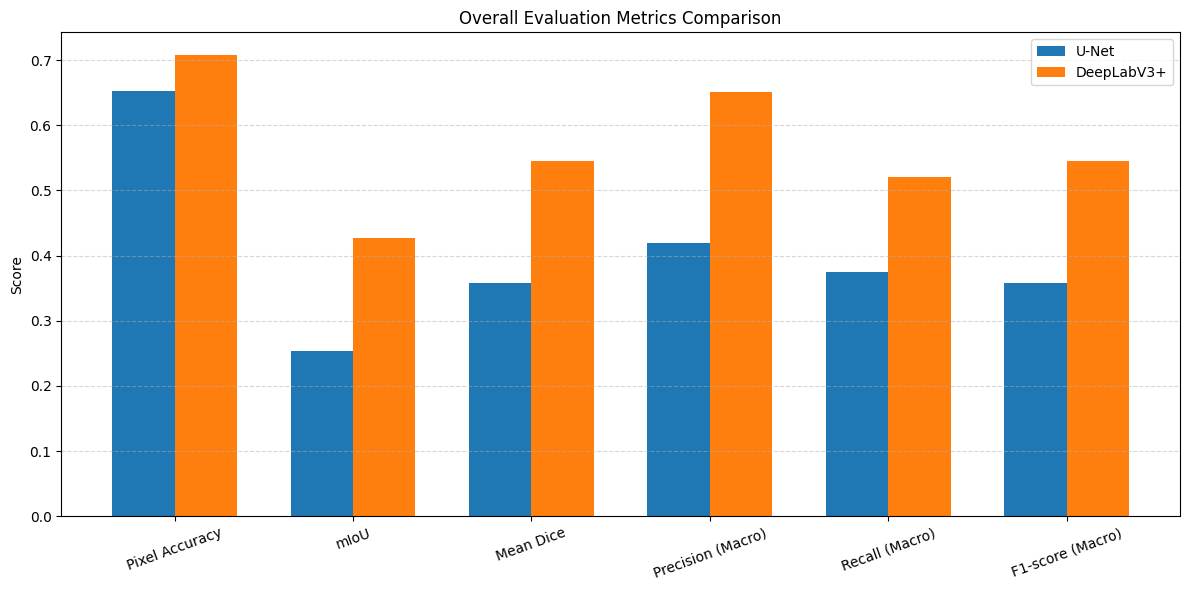

In [99]:
# ---------------------------------------------------------------------
# Imports for numerical processing and visualization
# This section imports NumPy for numerical operations and Matplotlib
# for creating comparative visualizations of model performance.
# ---------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt


# ---------------------------------------------------------------------
# Metric selection for comparison
# Defines the set of key evaluation metrics used to compare the
# performance of the U-Net and DeepLabV3+ models.
# ---------------------------------------------------------------------
metric_names = [
    "Pixel Accuracy",
    "mIoU",
    "Mean Dice",
    "Precision (Macro)",
    "Recall (Macro)",
    "F1-score (Macro)"
]

unet_vals = [metrics_unet[m] for m in metric_names]
deeplab_vals = [metrics_deeplab[m] for m in metric_names]


# ---------------------------------------------------------------------
# Bar chart configuration
# Prepares positional indices and bar width for side-by-side
# visualization of model performance across selected metrics.
# ---------------------------------------------------------------------
x = np.arange(len(metric_names))
width = 0.35


# ---------------------------------------------------------------------
# Metric comparison visualization
# This block generates a grouped bar chart to visually compare the
# overall evaluation metrics of the U-Net and DeepLabV3+ models.
# ---------------------------------------------------------------------
plt.figure(figsize=(12, 6))
plt.bar(x - width/2, unet_vals, width, label="U-Net")
plt.bar(x + width/2, deeplab_vals, width, label="DeepLabV3+")

plt.xticks(x, metric_names, rotation=20)
plt.ylabel("Score")
plt.title("Overall Evaluation Metrics Comparison")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()


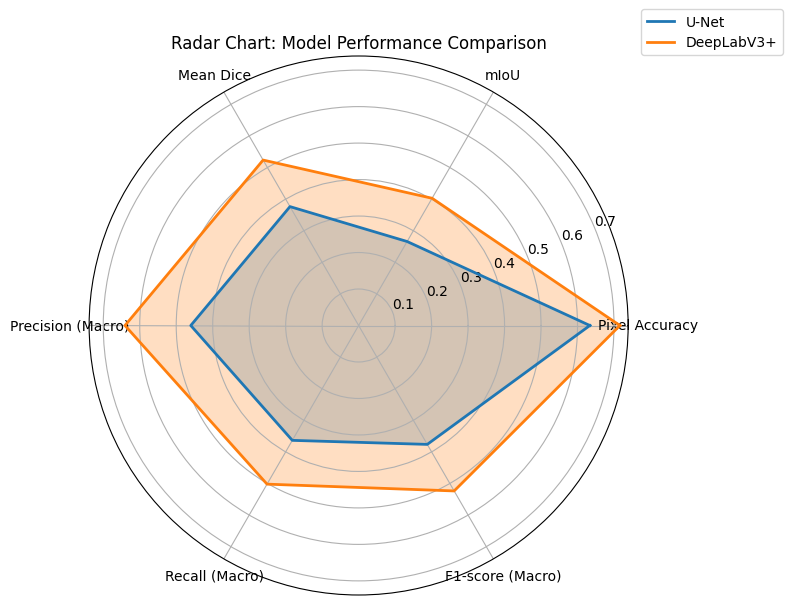

In [ ]:
# ---------------------------------------------------------------------
# Radar chart visualization for model performance
# This block creates a radar (spider) chart to compare multiple
# evaluation metrics of the U-Net and DeepLabV3+ models in a single
# visual representation.
# ---------------------------------------------------------------------
from math import pi

labels = metric_names
unet_radar = unet_vals + [unet_vals[0]]
deeplab_radar = deeplab_vals + [deeplab_vals[0]]

angles = [n / float(len(labels)) * 2 * pi for n in range(len(labels))]
angles += angles[:1]

plt.figure(figsize=(7, 7))
ax = plt.subplot(111, polar=True)

ax.plot(angles, unet_radar, linewidth=2, label="U-Net")
ax.fill(angles, unet_radar, alpha=0.25)

ax.plot(angles, deeplab_radar, linewidth=2, label="DeepLabV3+")
ax.fill(angles, deeplab_radar, alpha=0.25)

ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_title("Radar Chart: Model Performance Comparison")
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))

plt.show()
